# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
traffic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  traffic-dataset.zip
replace Traffic Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
df=pd.read_csv('/content/Traffic Data.csv', index_col='date_time', parse_dates=['date_time'])

In [4]:
# using this data for plotting / less samples
df_plot=pd.read_csv('/content/Traffic Data.csv',nrows=200 ,index_col='date_time', parse_dates=['date_time'])

In [5]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear
...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

Understanding Data Structure

In [6]:
df.shape

(20000, 7)

In [7]:
df.dtypes

,0
traffic_volume,float64
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object


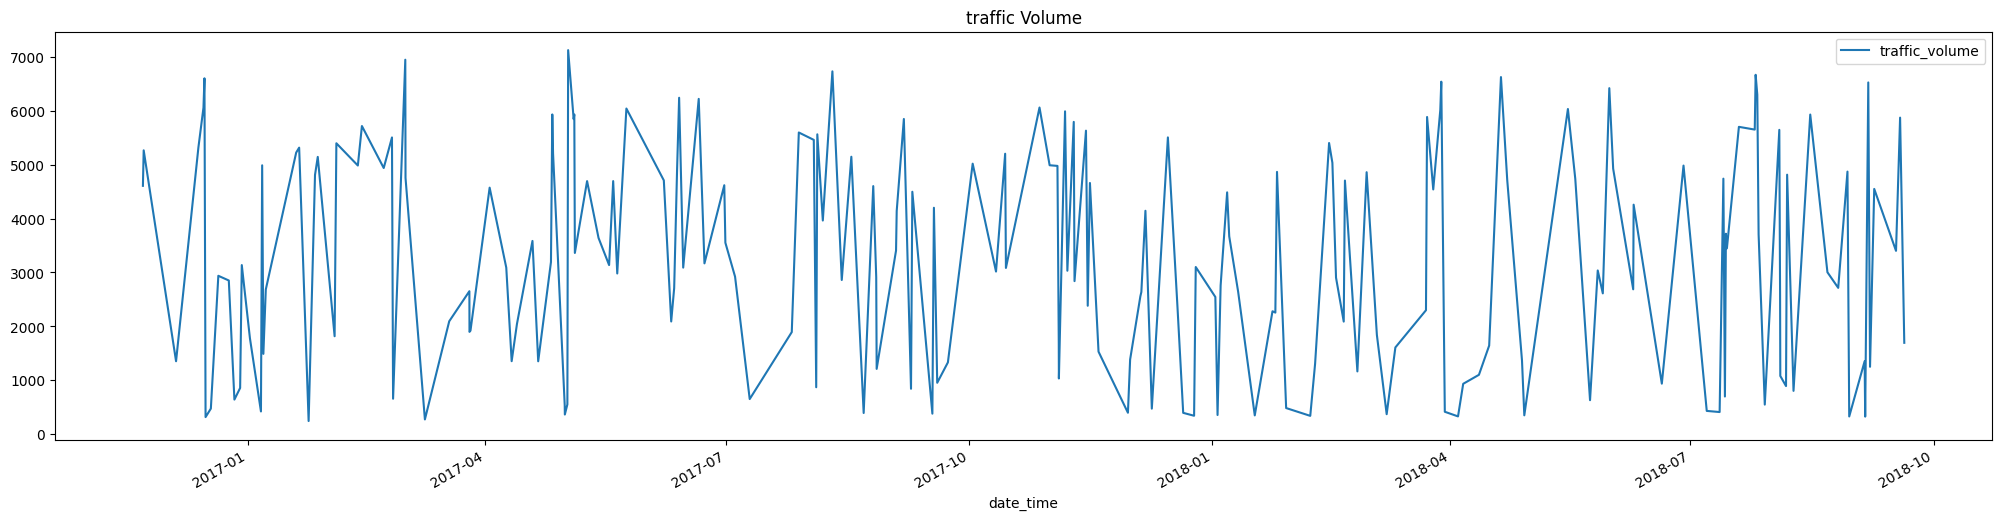

In [8]:
#plotting the traffic_volume over years
df_plot['traffic_volume'].plot(figsize=(25,6),legend=True)
plt.title('traffic Volume')
plt.show()

In [9]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


Handling missing values

In [10]:
# Handling missing values : seasonal_decompose does not handle missing values
df = df.dropna(subset=['traffic_volume'])

In [11]:
df_plot = df_plot.dropna(subset=['traffic_volume'])

In [12]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [13]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear
...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_plot['traffic_volume'],
                            model ='multiplicative', period=7)

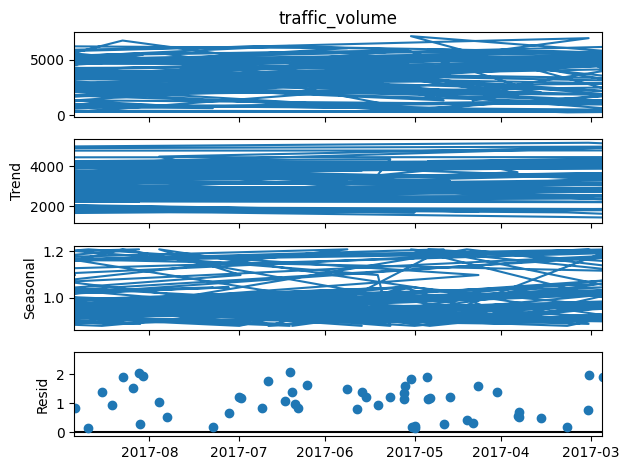

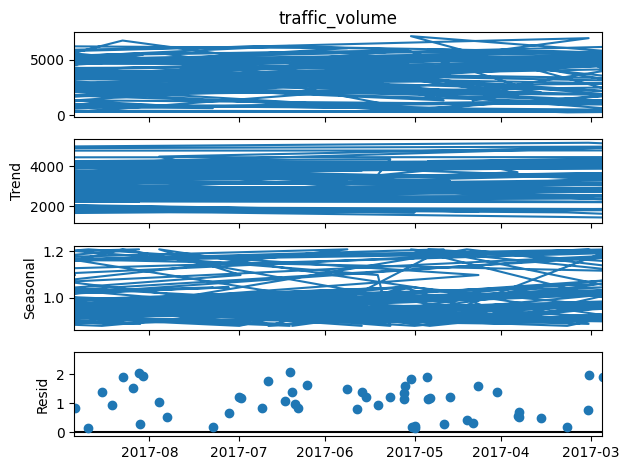

In [15]:
result.plot()

# data is not sorted increasingly based on the figure

Sortting Data

In [16]:
is_sorted = df.index.is_monotonic_increasing

In [17]:
is_sorted

False

In [18]:
df = df.sort_index(ascending=True)

In [19]:
df_plot = df_plot.sort_index(ascending=True)

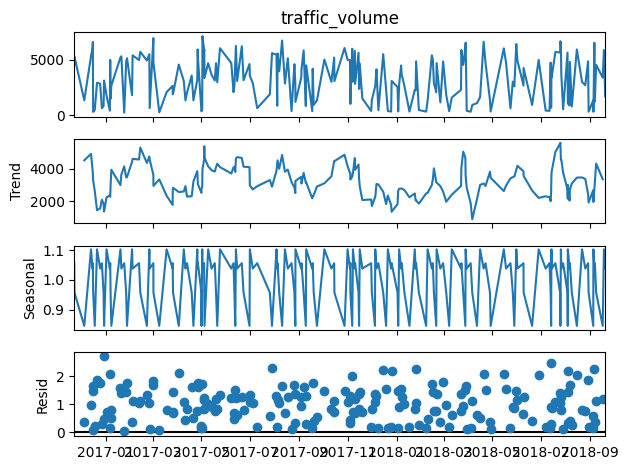

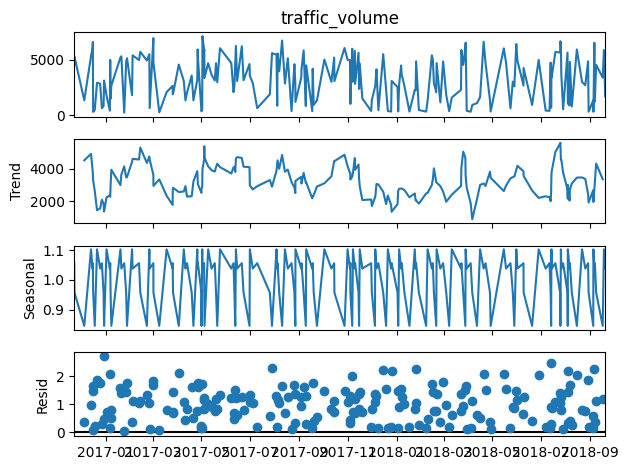

In [20]:
# on part of data
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_plot['traffic_volume'],
                            model ='multiplicative', period=5)

result.plot()

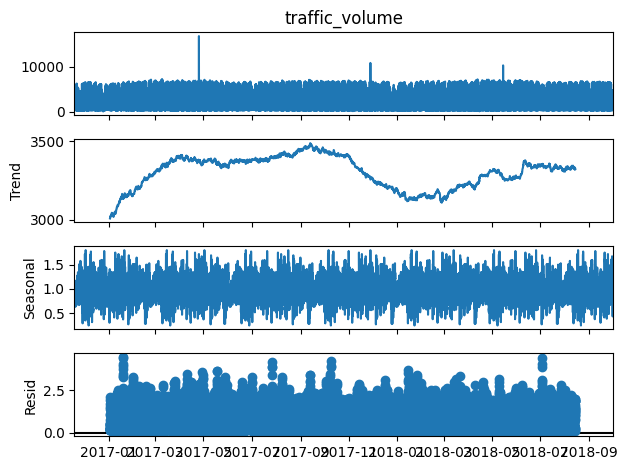

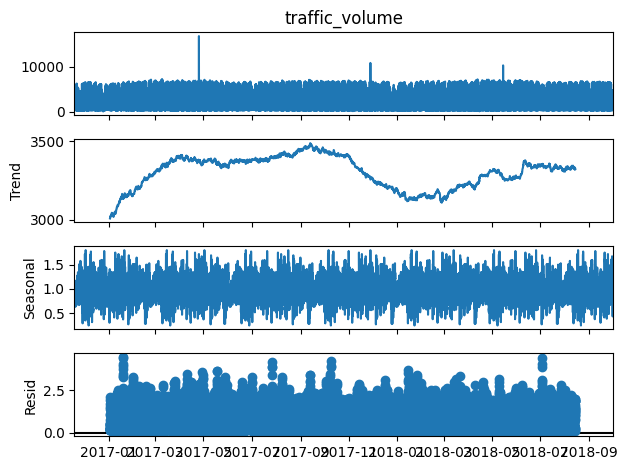

In [21]:
# all data samples
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['traffic_volume'],
                            model ='multiplicative', period=3000)

result.plot()

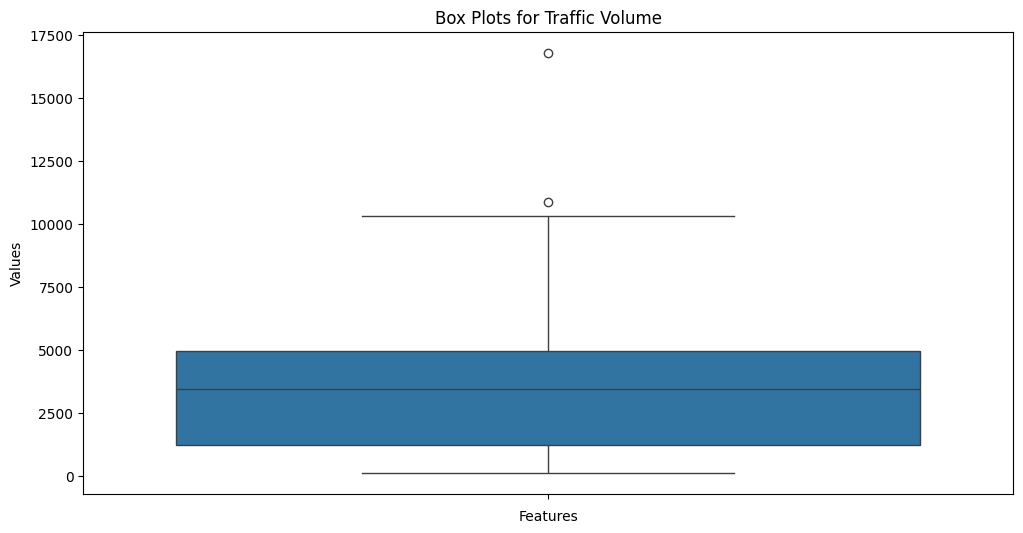

In [22]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(y='traffic_volume', data=df)
plt.title('Box Plots for Traffic Volume')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

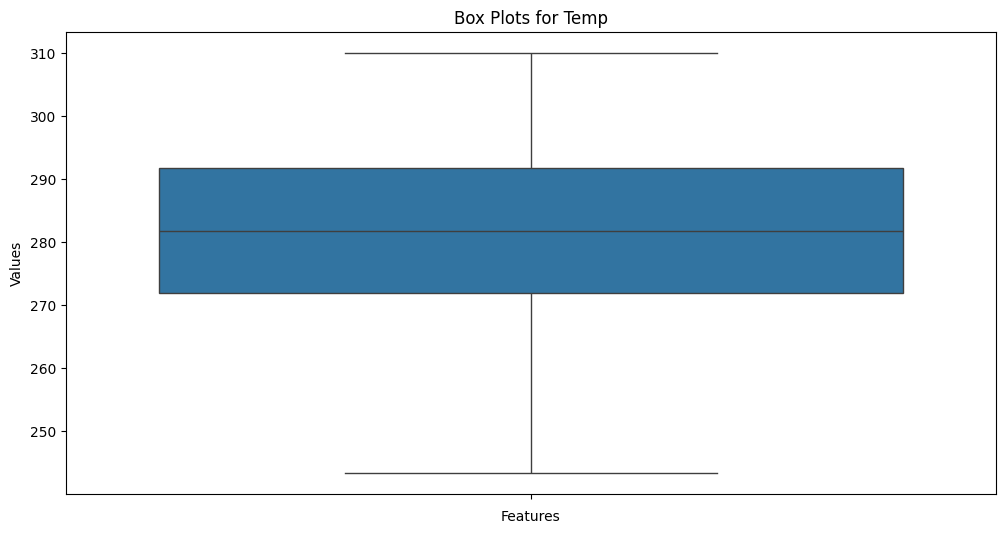

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='temp', data=df)
plt.title('Box Plots for Temp')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

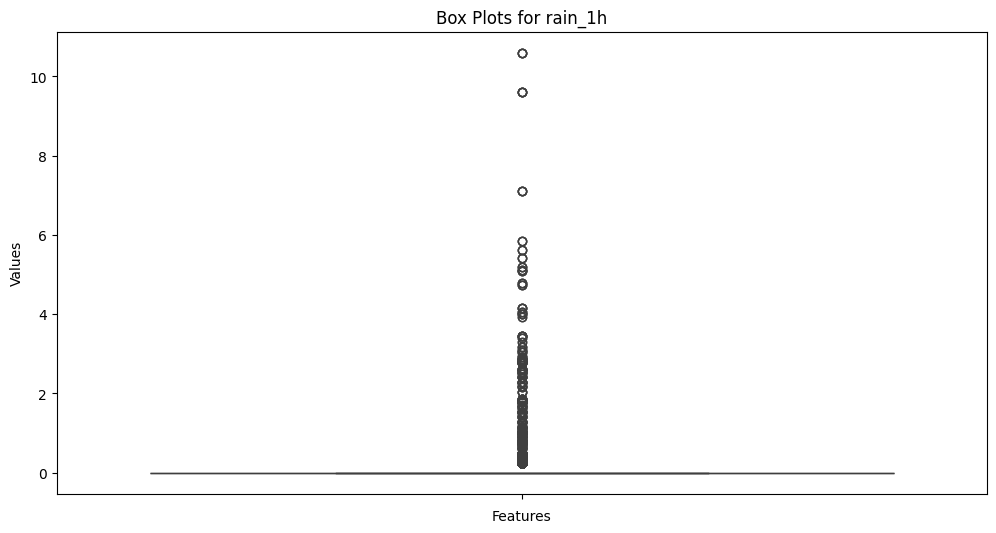

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='rain_1h', data=df)
plt.title('Box Plots for rain_1h')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

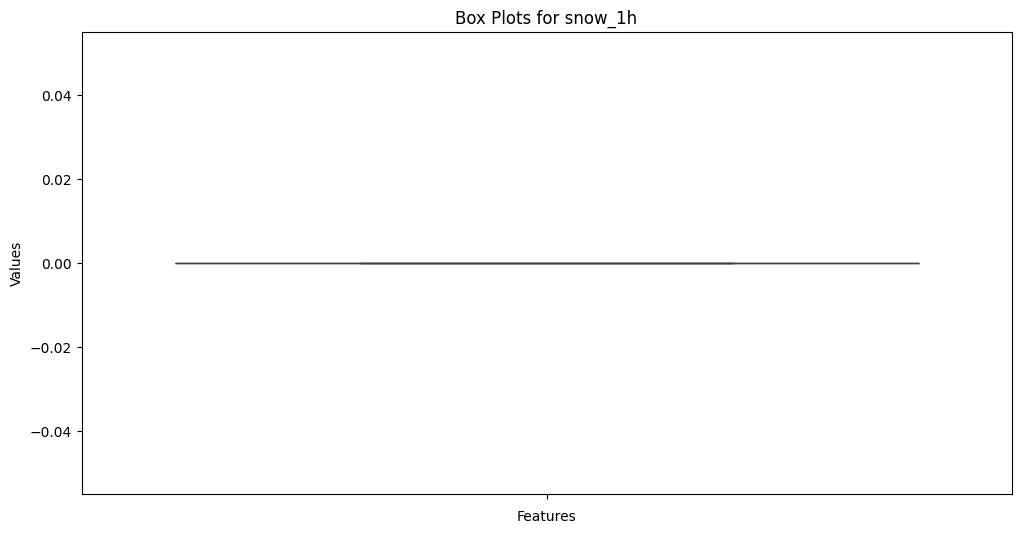

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='snow_1h', data=df)
plt.title('Box Plots for snow_1h')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

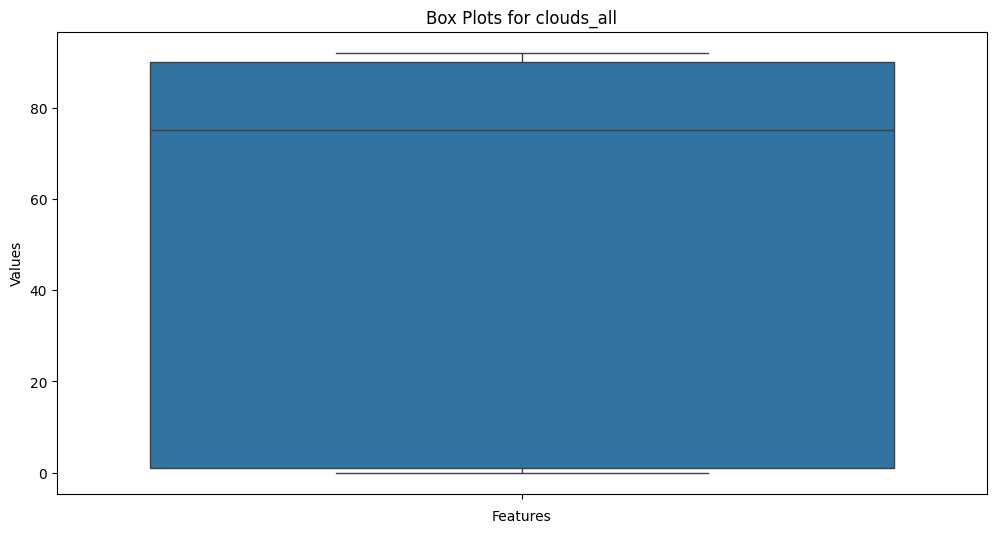

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='clouds_all', data=df)
plt.title('Box Plots for clouds_all')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

Handling Outliers

In [27]:
Q1 = df['traffic_volume'].quantile(0.25)
Q3 = df['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['traffic_volume'] >= lower_bound) & (df['traffic_volume'] <= upper_bound)]

In [28]:
Q1 = df['snow_1h'].quantile(0.25)
Q3 = df['snow_1h'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['snow_1h'] >= lower_bound) & (df['snow_1h'] <= upper_bound)]

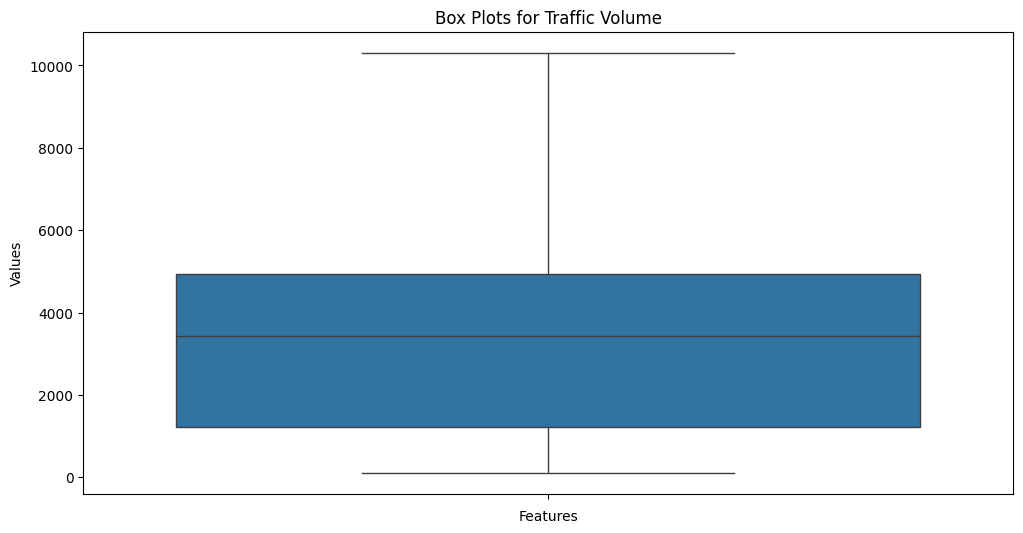

In [29]:
#  checking after handling outliers / good
plt.figure(figsize=(12, 6))
sns.boxplot(y='traffic_volume', data=df)
plt.title('Box Plots for Traffic Volume')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

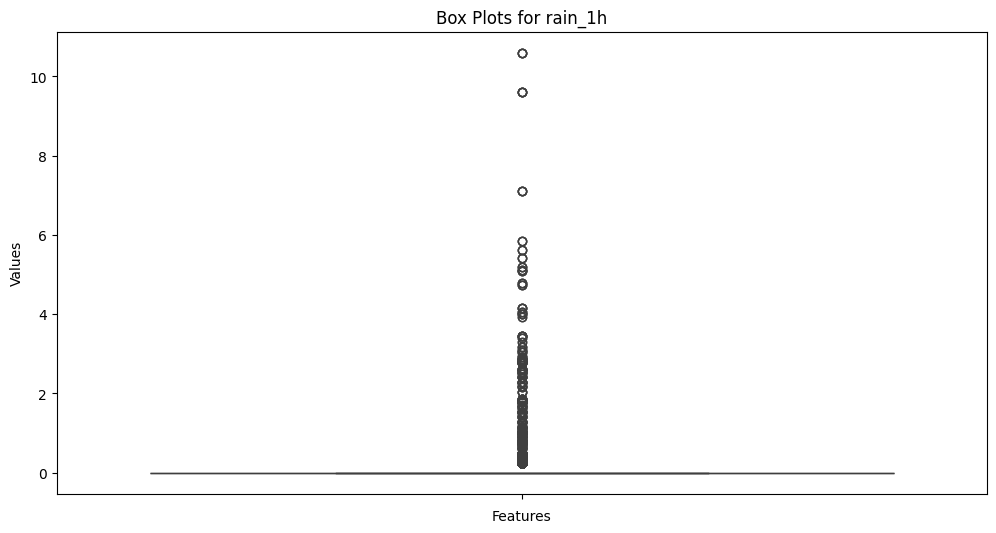

In [30]:
#  checking after handling outliers / still there is outliers
plt.figure(figsize=(12, 6))
sns.boxplot(y='rain_1h', data=df)
plt.title('Box Plots for rain_1h')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset. DONE before
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly. DONE before

Do more if needed!

In [31]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [32]:
is_sorted = df.index.is_monotonic_increasing
is_sorted

True

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['weather_main'] = encoder.fit_transform(df['weather_main'])

In [34]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['weather_description'] = encoder.fit_transform(df['weather_description'])

In [35]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,8,9
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,5,16
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3,4
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,8,9
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,5,16
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,1,1
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,1,18
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,9,20


resample the data to ensure consistent time intervals

In [36]:
# resampled into hourly intervals
df = df.resample('H').mean()

In [37]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90.0,5.333333,9.666667
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90.0,5.333333,9.666667
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90.0,5.333333,9.666667
2016-11-18 18:00:00,3486.0,273.59,0.0,0.0,90.0,6.500000,12.500000
2016-11-18 19:00:00,2524.0,273.58,0.0,0.0,90.0,6.500000,15.500000
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75.0,1.000000,1.000000
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90.0,1.000000,18.000000
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90.0,9.000000,20.000000


In [38]:
df.shape

(16353, 7)

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


Using Shift Method

In [39]:
# df_2 = pd.DataFrame()
df['prev_traffic_volume'] = df['traffic_volume'].shift()


Difference between traffic_volume

In [41]:
df['Volume_Change'] = df['traffic_volume'].diff()

Date Features


In [42]:
df['Day_of_Week'] = df.index.dayofweek

df['Month'] = df.index.month

df['Day_of_Year'] = df.index.day_of_year

In [43]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,Volume_Change,Day_of_Week,Month,Day_of_Year
date_time,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90.0,5.333333,9.666667,NaN,NaN,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90.0,5.333333,9.666667,4872.0,202.0,4,11,323
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90.0,5.333333,9.666667,5074.0,-746.0,4,11,323
2016-11-18 18:00:00,3486.0,273.59,0.0,0.0,90.0,6.500000,12.500000,4328.0,-842.0,4,11,323
2016-11-18 19:00:00,2524.0,273.58,0.0,0.0,90.0,6.500000,15.500000,3486.0,-962.0,4,11,323
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75.0,1.000000,1.000000,3947.0,-404.0,6,9,273
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90.0,1.000000,18.000000,3543.0,-762.0,6,9,273
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90.0,9.000000,20.000000,2781.0,-622.0,6,9,273


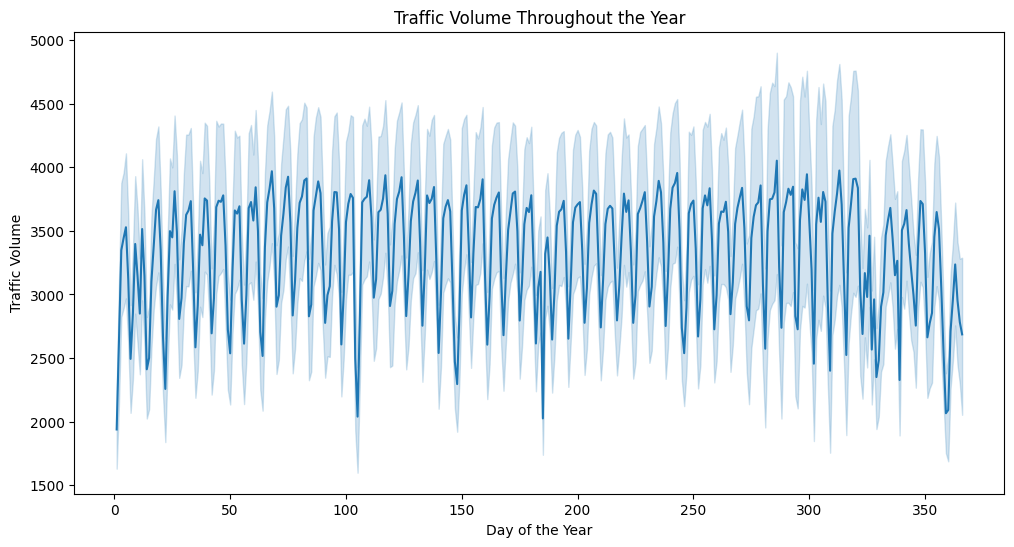

In [44]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Day_of_Year', y='traffic_volume')
plt.xlabel('Day of the Year')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Throughout the Year')
plt.show()

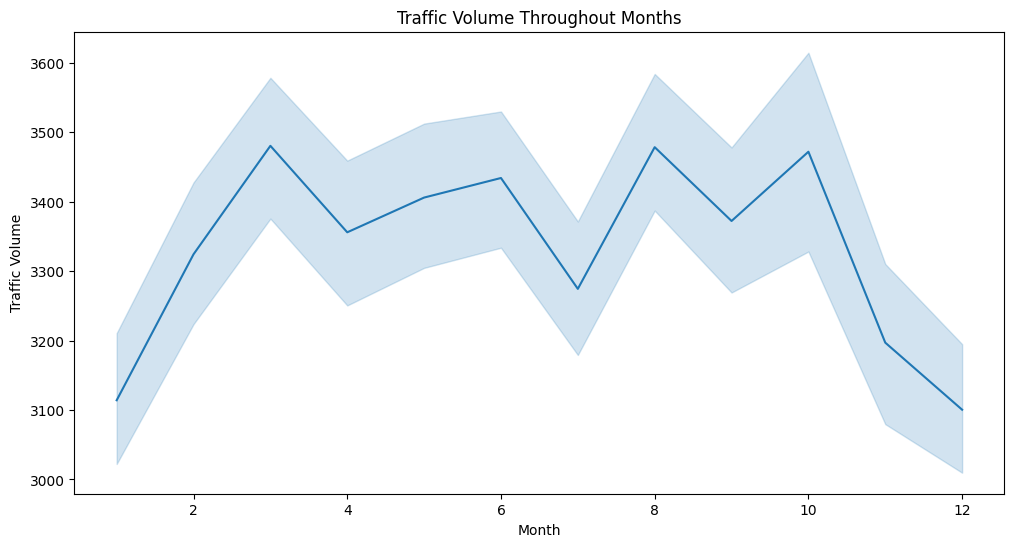

In [45]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='traffic_volume')
plt.xlabel('Month')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Throughout Months')
plt.show()

In [46]:
df = df.drop(df.index[0])

In [47]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,Volume_Change,Day_of_Week,Month,Day_of_Year
date_time,,,,,,,,,,,,
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90.0,5.333333,9.666667,4872.0,202.0,4,11,323
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90.0,5.333333,9.666667,5074.0,-746.0,4,11,323
2016-11-18 18:00:00,3486.0,273.59,0.0,0.0,90.0,6.500000,12.500000,4328.0,-842.0,4,11,323
2016-11-18 19:00:00,2524.0,273.58,0.0,0.0,90.0,6.500000,15.500000,3486.0,-962.0,4,11,323
2016-11-18 20:00:00,2027.0,273.28,0.0,0.0,90.0,6.500000,15.500000,2524.0,-497.0,4,11,323
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75.0,1.000000,1.000000,3947.0,-404.0,6,9,273
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90.0,1.000000,18.000000,3543.0,-762.0,6,9,273
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90.0,9.000000,20.000000,2781.0,-622.0,6,9,273


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [48]:
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']

In [49]:
def Split_data(df):
    training_size = int(len(df) * 0.70)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

In [50]:
df_train, df_test = Split_data(df)

In [51]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(df_train)
testing_set_scaled = sc.transform(df_test)

In [52]:
def create_dataset(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [53]:
X_train, y_train = create_dataset(training_set_scaled)
X_test, y_test = create_dataset(testing_set_scaled)
X_train, X_test = FeatureFixShape(X_train, X_test)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.DONE before

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [54]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
history=regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
4292/4292 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: nan
Epoch 2/5
4292/4292 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: nan
Epoch 3/5
4292/4292 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: nan
Epoch 4/5
4292/4292 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: nan
Epoch 5/5
4292/4292 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: nan


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [56]:
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)

4292/4292 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# On test data
mae = mean_absolute_error(y_test, testPredict)
mse = mean_squared_error(y_test, testPredict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - testPredict) / y_test)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


ValueError: Input contains NaN.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', marker='o')
plt.plot(testPredict, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [ ]:
regressorGRU = Sequential()

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.5))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.3))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.3))

regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.5))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')


In [ ]:
history=regressorGRU.fit(X_train,y_train,epochs=5,batch_size=150)

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
trainPredict = regressorGRU.predict(X_train)
testPredict = regressorGRU.predict(X_test)

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
# On test data
mae = mean_absolute_error(y_test, testPredict)
mse = mean_squared_error(y_test, testPredict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - testPredict) / y_test)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', marker='o')
plt.plot(testPredict, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:



1.   there was missig data 20 in the traffic volum so I drop them becase data 20000 recored also I handled Outlier
2.   

